# Convoluted Neural Network

In [1]:
''' Needed libraries '''

import numpy as np # For matrix operations and numerical processing
import matplotlib.pyplot as plt # For plotting
import os, sys # For filepaths
# Neural Network libraries:
import torch
from torch import nn
from torch.utils.data import DataLoader

In [2]:
''' Add the datasets and libraries to the system path '''

# Find the path to our implementations
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
home_directory = os.path.dirname(parent_directory)
libraries_path = os.path.join(home_directory, 'Libraries')

# Find the path to the datasets
datasets_path = os.path.join(home_directory, 'Datasets')

# Add them both to the system path
sys.path.append(datasets_path)
sys.path.append(libraries_path)

In [3]:
''' Loading in the training and test sets '''

training_set = np.load(os.path.join(datasets_path, 'fashion_train.npy'))  # Load training set
train_X = training_set[:, :-1] # Define X as all columns except the last one
train_y = training_set[:, -1] # Define y as the last column

test_set = np.load(os.path.join(datasets_path, 'fashion_test.npy'))  # Load test set
test_X = test_set[:, :-1] # Define X as all columns except the last one
test_y = test_set[:, -1] # Define y as the last column


# Checking sizes of datasets
print(train_X.shape) # 10000 pictures, 784 pixels each
print(train_y.shape) # 10000 labels
print(test_X.shape) # 5000 pictures, 784 pixels each
print(test_y.shape) # 5000 labels


print(train_X[0].shape) # Pictures are vectors with length 784
plot = train_X[0].reshape(28, 28) # Pictures need to be reshaped to 28x28 to be plotted (784 pixels total)
print(plot.shape) # Pictures are now 28x28

(10000, 784)
(10000,)
(5000, 784)
(5000,)
(784,)
(28, 28)


In [4]:
''' Resize the pixel values to have mean 0 and standard deviation 1 '''
# Calculate the mean and standard deviation of the training set
mean = np.mean(train_X)
std = np.std(train_X)

# Apply the transformation to both the training and test sets
train_X = (train_X - mean) / std
test_X = (test_X - mean) / std

In [5]:
''' Convert the data to tensors to be used by PyTorch '''
tensor_train_X = torch.from_numpy(train_X).float()
tensor_train_y = torch.from_numpy(train_y).long()
tensor_test_X = torch.from_numpy(test_X).float()
tensor_test_y = torch.from_numpy(test_y).long()

In [6]:
''' Reshape all items in both sets to be 28x28 instead of 784x1 '''
tensor_train_X = tensor_train_X.reshape(-1, 1, 28, 28)
tensor_test_X = tensor_test_X.reshape(-1, 1, 28, 28)

In [7]:
''' Creating models '''

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


# Define model
class NeuralNetwork(nn.Module):
    def __init__(self,ks=3, pad=1):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=ks, padding=pad),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=ks, padding=pad),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 14 * 14, 128),
            nn.ReLU(),
            nn.Linear(128, 5),
        )


    def forward(self, x):
        logits = self.stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (stack): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=12544, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=5, bias=True)
  )
)


In [8]:
''' Training loop '''

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [9]:
''' Test loop '''
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [10]:
''' Run CNN '''

def runCNN(epochs, learning_rate, batch_size, ks, pad):

    # Define model
    model = NeuralNetwork(ks, pad).to(device)
    print(model)

    # Define loss function
    loss_fn = nn.CrossEntropyLoss()

    # Define optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Define data loaders
    train_loader = DataLoader(list(zip(tensor_train_X, tensor_train_y)), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(list(zip(tensor_test_X, tensor_test_y)), batch_size=batch_size, shuffle=False)
    
    for X, y in train_loader:
        print(f"Shape of X [N, C, H, W]: {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}")
        break

    # Train and test the model
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train(train_loader, model, loss_fn, optimizer)
        test(test_loader, model, loss_fn)
    print("Done!")

In [15]:
''' Choose parameters '''

epochs = 5
learning_rate = 1e-3
batch_size = 10000
ks = 3 # kernel size
pad = 1 # padding

In [16]:
''' Train (test) and save the model '''

# if file exists, load model
if not os.path.isfile("model.pth"):
    runCNN(epochs, learning_rate, batch_size, ks, pad)
    torch.save(model.state_dict(), "model.pth")
    print("Saved PyTorch Model State to model.pth")

else:
    model = NeuralNetwork().to(device)
    model.load_state_dict(torch.load("model.pth"))
    print("Loaded PyTorch Model State from model.pth")

NeuralNetwork(
  (stack): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=12544, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=5, bias=True)
  )
)
Shape of X [N, C, H, W]: torch.Size([10000, 1, 28, 28])
Shape of y: torch.Size([10000]) torch.int64
Epoch 1
-------------------------------
loss: 1.618698  [10000/10000]
Test Error: 
 Accuracy: 37.1%, Avg loss: 1.470264 

Epoch 2
-------------------------------
loss: 1.466794  [10000/10000]
Test Error: 
 Accuracy: 37.2%, Avg loss: 1.280982 

Epoch 3
-------------------------------
loss: 1.277330  [10000/10000]
Test Error: 
 Accuracy: 59.9%, Avg loss: 1.050422 

Epoch 4
-------------------------------
los

In [ ]:
''' Make predictions with the model '''

classes = np.load(os.path.join(datasets_path, 'labels_dict.npy'), allow_pickle=True).item()
print(classes)

test_data = np.load(os.path.join(datasets_path, 'fashion_test.npy'))  # Load test set
test_data_x = test_data[:, :-1]
test_data_y = test_data[:, -1]

# Normalize
mean = np.mean(test_data_x)
std = np.std(test_data_x)
test_data_x = (test_data_x - mean) / std

# Turn to tensor
tensor_test_data_x = torch.from_numpy(test_data_x).float()
tensor_test_data_y = torch.from_numpy(test_data_y).long()

# Reshape
tensor_test_data_x = tensor_test_data_x.reshape(-1, 1, 28, 28)

{0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Shirt'}


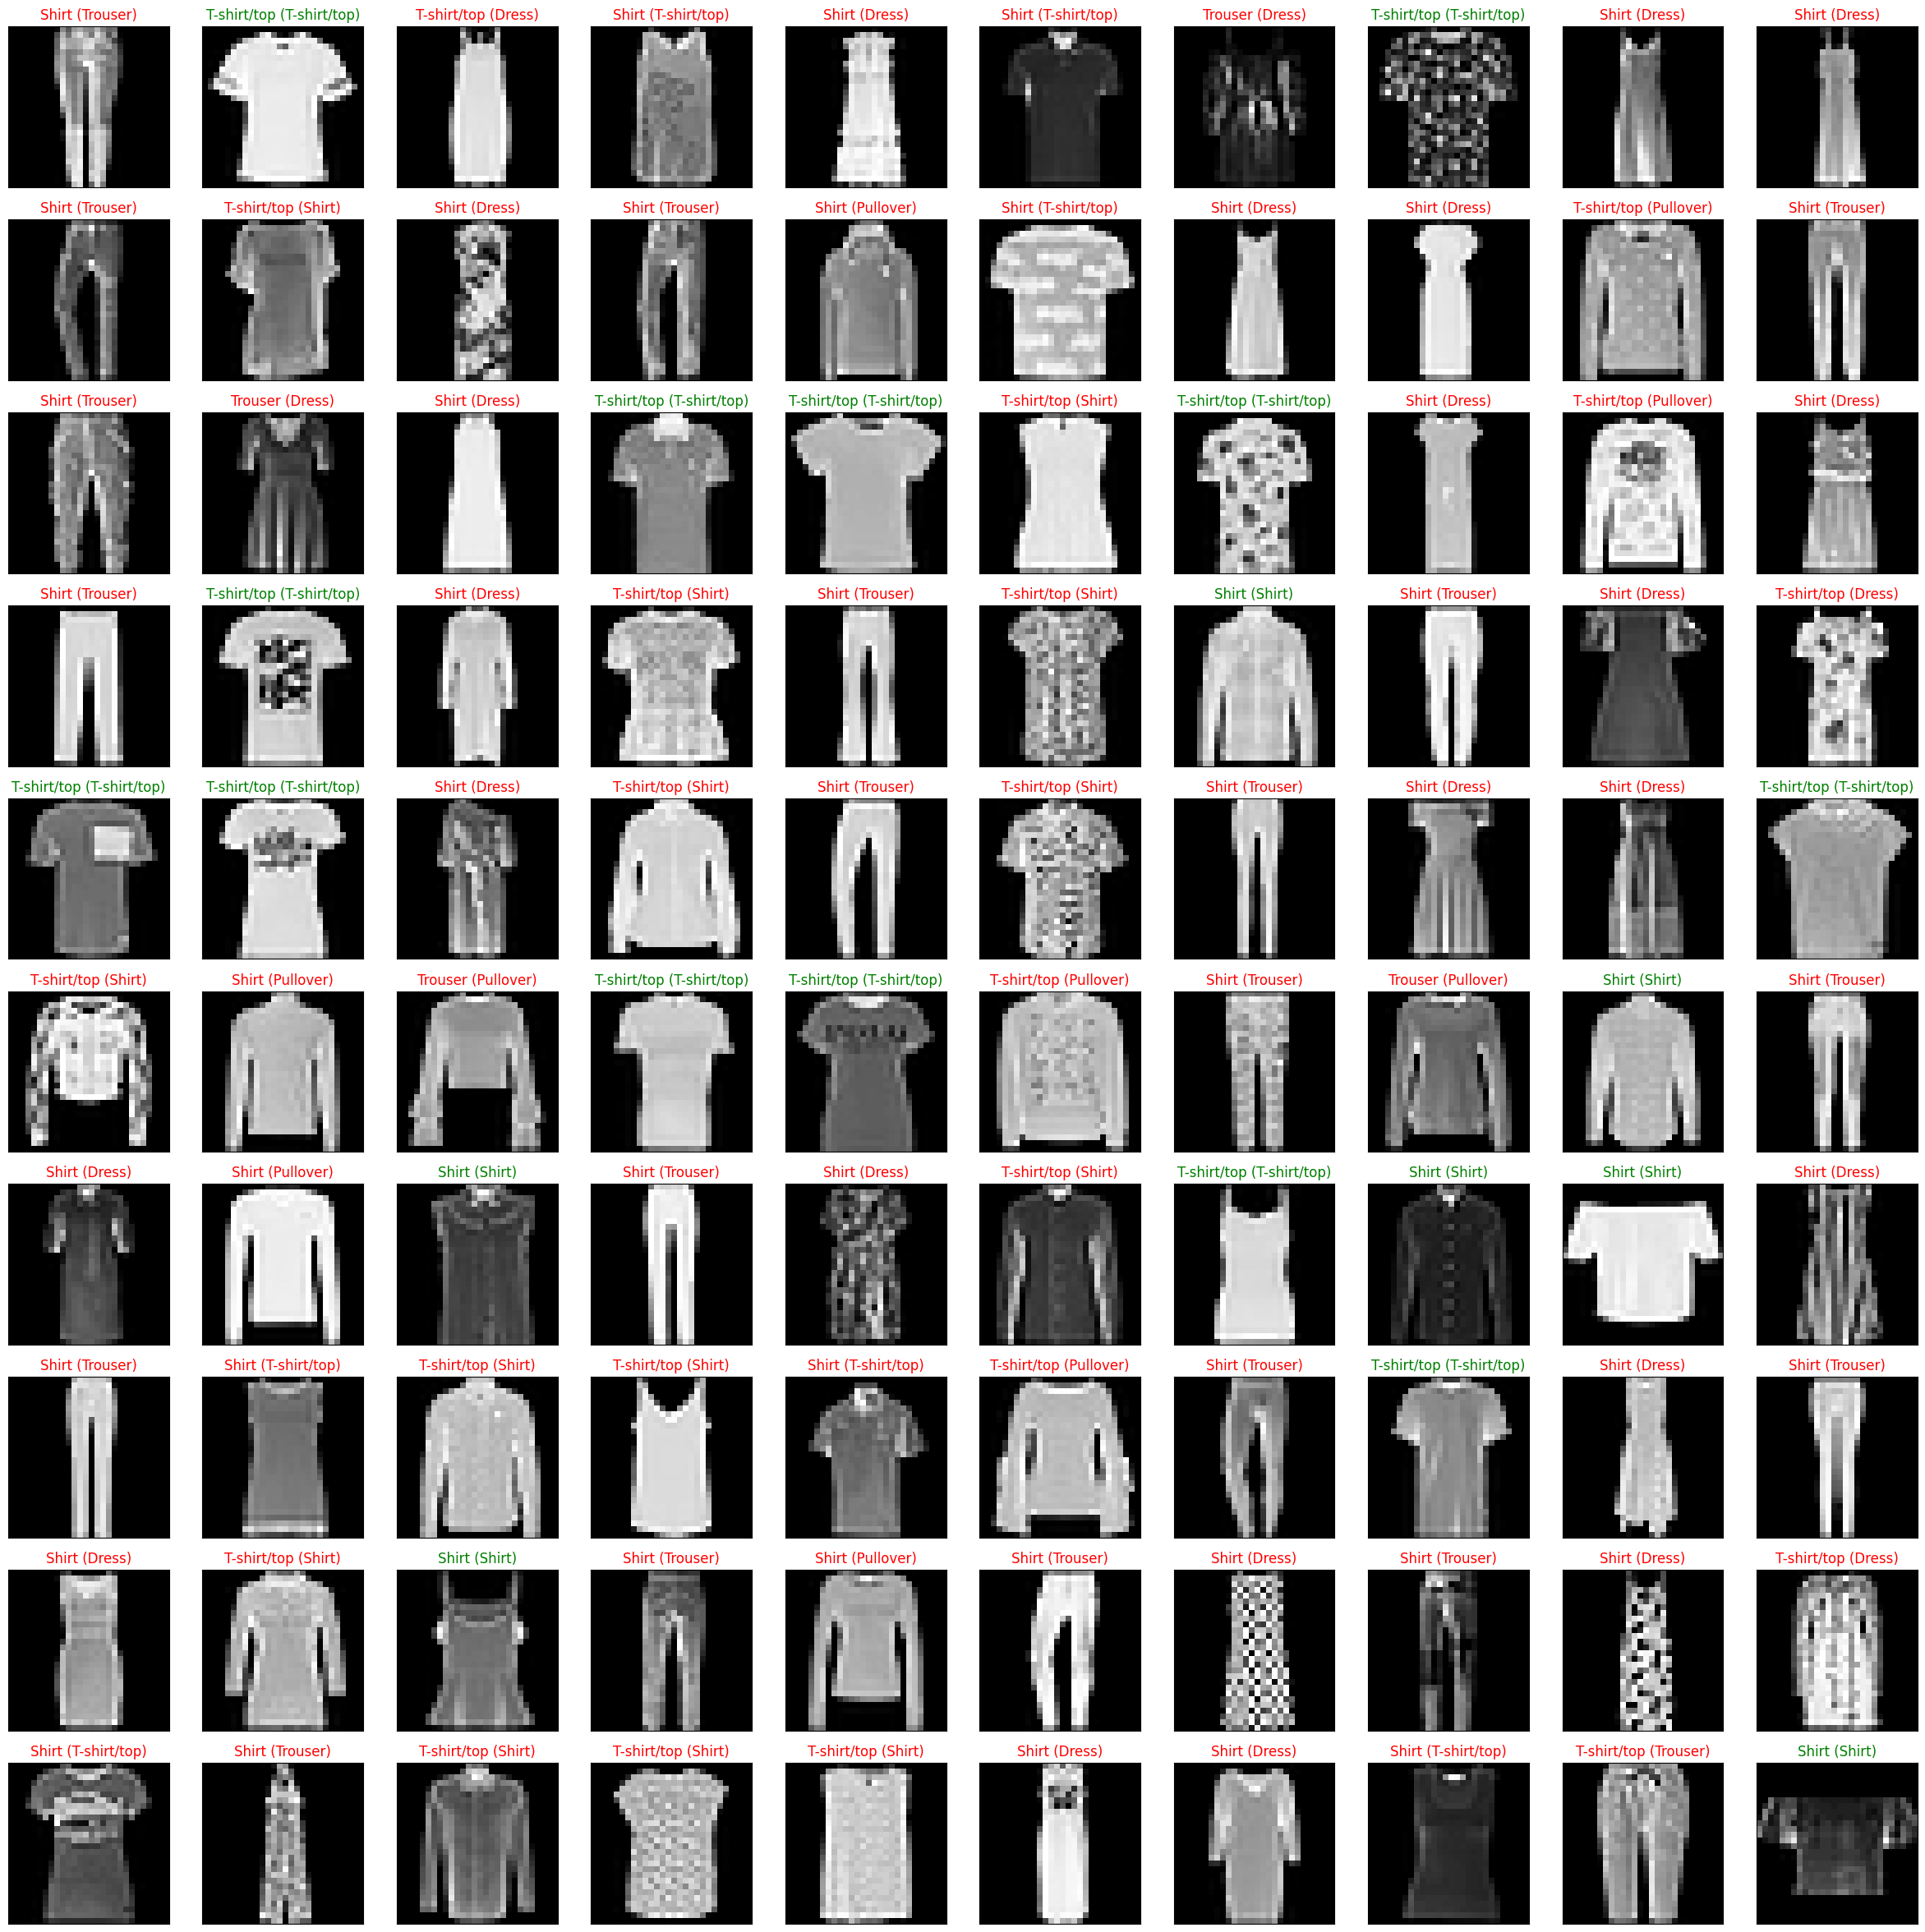

Accuracy:  0.226


In [ ]:
# Make predictions
with torch.no_grad():
    pred = model(tensor_test_data_x.to(device))

    # Plot the first 100 images in the test set
    fig = plt.figure(figsize=(30, 30))
    for i in range(100):
        ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
        ax.imshow(tensor_test_data_x[i].reshape(28, 28), cmap='gray')
        pred_idx = torch.argmax(pred[i])
        true_idx = tensor_test_data_y[i]
        ax.set_title("{} ({})".format(classes[pred_idx.item()], classes[true_idx.item()]),
                     color=("green" if pred_idx == true_idx else "red"))
    plt.show()


# Plot random images from the test set, their predicted labels, and the true labels
# fig = plt.figure(figsize=(30, 30))
# i = np.random.randint(0, 5000)
# ax = fig.add_subplot(10, 10, 1, xticks=[], yticks=[])
# ax.imshow(tensor_test_data_x[i].reshape(28, 28), cmap='gray')
# pred_idx = torch.argmax(pred[i])
# true_idx = tensor_test_data_y[i]
# ax.set_title("{} ({})".format(classes[pred_idx.item()], classes[true_idx.item()]),
#              color=("green" if pred_idx == true_idx else "red"))
# plt.show()


''' Calculate accuracy '''

# Calculate accuracy
correct = 0
total = 0
with torch.no_grad():
    for i in range(len(tensor_test_data_x)):
        real_class = tensor_test_data_y[i]
        net_out = model(tensor_test_data_x[i].view(-1, 1, 28, 28).to(device))[0]
        predicted_class = torch.argmax(net_out)
        if predicted_class == real_class:
            correct += 1
        total += 1
print("Accuracy: ", round(correct / total, 3))